<a href="https://colab.research.google.com/github/ellagattis/kuka/blob/main/SLforLCcircuit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train a network to fit the frequency response of a filter
1. Analytic representation of filter
1. Use filter to filter some random noise
1. Use the input noise and the filter output to train the network

In [ ]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

#import tensorflow as tf
#from tensorflow import keras

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Reshape, Dropout
from keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D
from keras.callbacks import Callback, History, LearningRateScheduler
import keras.optimizers



plt.rcParams.update({'text.usetex': False,
                     'lines.linewidth': 4,
                     'font.family': 'serif',
                     'font.serif': 'Palatino',
                     'font.size': 22,
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.labelsize': 'medium',
                     'ytick.labelsize': 'medium',
                     'axes.labelsize': 'medium',
                     'axes.titlesize': 'medium',
                     'axes.grid.axis': 'both',
                     'axes.grid.which': 'both',
                     'axes.grid': True,
                     'grid.color': 'xkcd:beige',
                     'grid.alpha': 0.253,
                     'lines.markersize': 12,
                     'legend.borderpad': 0.2,
                     'legend.fancybox': True,
                     'legend.fontsize': 'small',
                     'legend.framealpha': 0.8,
                     'legend.handletextpad': 0.5,
                     'legend.labelspacing': 0.33,
                     'legend.loc': 'best',
                     'figure.figsize': ((12, 8)),
                     'savefig.dpi': 140,
                     'savefig.bbox': 'tight',
                     'pdf.compression': 9})

In [ ]:
def plot_results(target, prediction, fs, nfft,
                 plotDir='.', title_str=None, plotStrain=False):

    residual = target - prediction

    ff1, pp = sig.welch([target, prediction, residual],
                        fs=fs, nperseg=nfft, axis=-1, average='median')
    ff2, co = sig.coherence(target, prediction,
                            fs=fs, nperseg=nfft)

        # make plots to evaluate success / failure of the regression
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True,
                                       figsize=(12, 12),
                                       gridspec_kw={'height_ratios':[3, 1]})

    labels = ['Target', 'Prediction', 'Residual']
    strain = np.sqrt(pp).T
    
    for i in range(3):
        ax1.loglog(ff1.T, strain[:,i],
                    alpha = 0.8,
                    rasterized=True,
                       label=labels[i])
    ax1.set_yticks([10**-10,10**-9,10**-8,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2,10**-1,10**0])
    ax2.set_ylim([10**-10, 10**0])
    ax1.legend(fontsize='small')
    ax1.set_ylabel(r'Power Spectral Density')
    #ax1.set_xlim([7, 150])
    ax1.grid(True, which='minor')

    ax2.semilogx(ff2.T, co,
                 label = 'Target/Prediction',
                 c = 'xkcd:poop brown',
                 rasterized = True)
    ax2.grid(True, which='minor')
    ax2.set_ylim([0, 1.1])
    ax2.set_xlabel(r'Frequency (Hz)')
    ax2.set_ylabel(r'Coherence')

    ax2.legend(fontsize='x-small')

    plt.subplots_adjust(hspace=0.05)


# learning rate schedule
def rate_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10
    lrate = initial_lrate * drop**(np.log10((epoch+1)/epochs_drop))
    return lrate


#Generate a large (1000 signals) amount of data

def make_data(dur = 8, fs = 128, sos=[1,0,0,0]):
    Inoisy = np.random.randn(dur * fs)
    
    output = sig.sosfilt(sos,  Inoisy)
    
    return Inoisy, output

<b>equations for LC circuit:</b>

$$L^2\frac{d^2i}{dt^2}+\frac1Ci=0$$

energy stored in electric field of capacitor $U_E=\frac12\frac{Q^2}{C}$, energy storedin magnetic field of inductor $U_B=\frac12LI^2$, total energy $U=U_E+U_B$ is constant so $\frac{dU}{dt}=0=\frac{Q}{C}\frac{dQ}{dt}+LI\frac{dI}{dt}=\frac{Q}{C}\frac{dQ}{dt}+L\frac{dQ}{dt}\frac{d^2Q}{dt^2}$, so $\frac{d^2Q}{dt^2}=-\frac{Q}{LC}$

angular frequency of oscillations:

$$\omega = \sqrt{\frac{1}{LC}}=2\pi f$$

so equation of motion for charge is 

$$\frac{d^2Q}{dt^2}=-\omega^2Q, \ \ \ \ Q=A\cos(\omega t+\phi)$$

charge on capacitor: 

$$Q(t)=Q_{max}\cos(\omega t+\phi)$$

current:

$$I(t) = \frac{dq(t)}{dt}=-\omega Q_{max}\sin(\omega t+\phi)=I_{max}\sin(\omega t+\phi)$$
$$U(t)=\frac{Q_{max}^2}{2C}$$


In [ ]:
# Set up parameters for LC circuit 
L = 2.0e-1                      # inductance in Henrys
C = 5.0e-3                      # capacitance in Farads
omega = 1/(np.sqrt(L*C))        # resonance frequency of the circuit in rad/s
print(omega/(2*np.pi))

5.032921210448704


In [ ]:
# Create an order 3 lowpass butterworth filter.
b, a = sig.butter(3, 0.05)
# Use filtfilt to apply the filter.
#y = sig.filtfilt(b, a, Inoisy)

In [ ]:
#
fs = 256

# Generate a noisy signal to be filtered.
t = np.linspace(0, 1, 1*fs)

Inoisy = np.random.randn(len(t))

# This is a bandpass
f1    = 3
f2    = 15
sosBP = sig.butter(4, [f1/(fs/2), f2/(fs/2)], btype='bandpass', output='sos')
b,a = sig.butter(4, [2*np.pi*f2], analog=True, btype='lowpass', output='ba')

# filter the data using many second-order-sections
out    = sig.sosfilt(sosBP,  Inoisy)

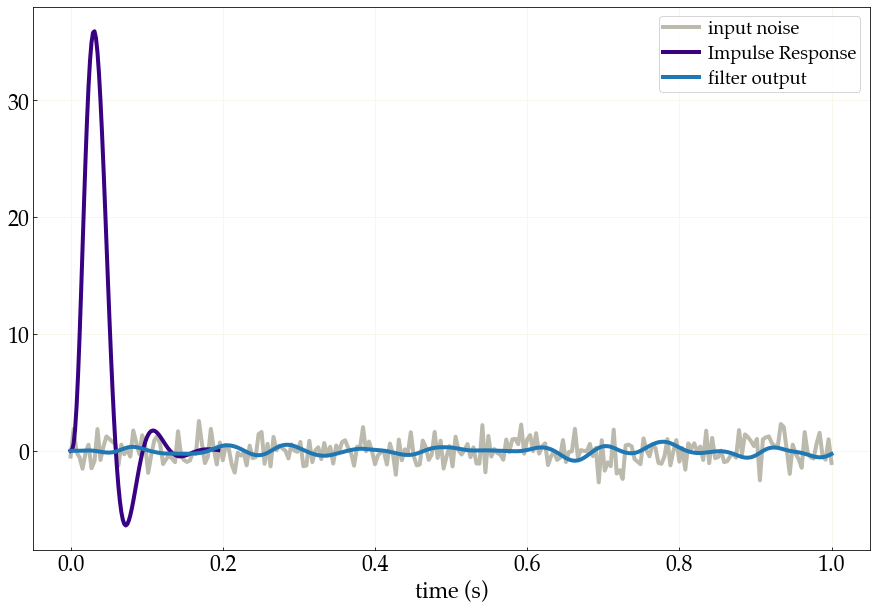

In [ ]:
# Make the plot.
fig, ax = plt.subplots(figsize=(15,10))

t2, y2 = sig.impulse((b,a))

ax.plot(t, Inoisy, c='xkcd:Cement', alpha=0.75, label='input noise')
#ax.plot(t, I, 'y--')
ax.plot(t2, y2, 'xkcd:Indigo', label='Impulse Response')
ax.plot(t, out, label='filter output')

ax.legend()
ax.set_xlabel('time (s)')


plt.show()

### Now use pwelch to plot the PSD of the filter output

In [ ]:
#initialise empty lists to add generated data to
noisy_list = []
filtered_list = []

In [ ]:
# make the training, testing, and validation data
data_dur = 8

noisydata_training, filterdata_training = make_data(dur=data_dur,   fs = fs, sos = sosBP)
noisydata_testing , filterdata_testing  = make_data(dur=int(data_dur/4), fs = fs, sos = sosBP)
noisydata_val , filterdata_val          = make_data(dur=int(data_dur*4), fs = fs, sos = sosBP)


In [ ]:
#change the list into 3d arrays with dimensionality (number of signals in list,number of data points in signal,1)
datachuncks = [noisydata_training, filterdata_training, 
               noisydata_testing, filterdata_testing,
               noisydata_val, filterdata_val]


noisydata_training = noisydata_training.reshape((1, noisydata_training.shape[0], 1))
noisydata_testing = noisydata_testing.reshape((1, noisydata_testing.shape[0], 1))
noisydata_val = noisydata_val.reshape((1, noisydata_val.shape[0], 1))
filterdata_training = filterdata_training.reshape((1, filterdata_training.shape[0], 1))
filterdata_testing = filterdata_testing.reshape((1, filterdata_testing.shape[0], 1))
filterdata_val = filterdata_val.reshape((1, filterdata_val.shape[0], 1))
    
print(noisydata_training.shape, filterdata_training.shape, noisydata_testing.shape, filterdata_testing.shape, noisydata_val.shape, filterdata_val.shape)

(1, 2048, 1) (1, 2048, 1) (1, 512, 1) (1, 512, 1) (1, 8192, 1) (1, 8192, 1)


In [ ]:
#model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(1000,1,)))

kernel_time = 4
input_num = 1 # its because we only have 1 random noise input for each filter
inputshape = (None, input_num)

model = Sequential()
model.add(Conv1D(filters     = 1, 
                 kernel_size = fs * kernel_time, 
                 activation  ='linear', 
                 input_shape = inputshape, 
                 padding     = 'same'))

#model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(keras.layers.Dropout(0.5))
#model.add(keras.layers.MaxPooling1D(pool_size=2))
#model.add(keras.layers.Flatten())
#model.add(keras.layers.Dense(32,activation='tanh'))
#model.add(keras.layers.Dense(1000,activation='tanh'))
#model.add(tf.keras.layers.Reshape((1000, 1)))

model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 1)           1025      
_________________________________________________________________
dense (Dense)                (None, None, 1)           2         
Total params: 1,027
Trainable params: 1,027
Non-trainable params: 0
_________________________________________________________________


In [ ]:
my_adam = keras.optimizers.Adam(learning_rate = 1e-3)
learning_rate_scheduler = LearningRateScheduler(rate_decay)

model.compile(optimizer=my_adam, loss='mean_squared_error')

In [ ]:
# fit network
history = History()
N_epochs = 555 # how many times to train the network on the same testing data

#model.fit(x=noisydata_training,y=filterdata_training,epochs=20,validation_split = 0.1)

model.fit(x = noisydata_training, y = filterdata_training,
                     epochs=N_epochs, batch_size=int(fs),
                     validation_data = (noisydata_testing, filterdata_testing),
                    callbacks=[history, learning_rate_scheduler])

Epoch 1/555
1/1 [==============================] - 0s 217ms/step - loss: 0.5376 - val_loss: 0.1702 - lr: 0.0200
Epoch 2/555
1/1 [==============================] - 0s 38ms/step - loss: 0.2072 - val_loss: 0.1022 - lr: 0.0162
Epoch 3/555
1/1 [==============================] - 0s 37ms/step - loss: 0.1241 - val_loss: 0.0739 - lr: 0.0144
Epoch 4/555
1/1 [==============================] - 0s 53ms/step - loss: 0.0999 - val_loss: 0.0609 - lr: 0.0132
Epoch 5/555
1/1 [==============================] - 0s 123ms/step - loss: 0.0885 - val_loss: 0.0522 - lr: 0.0123
Epoch 6/555
1/1 [==============================] - 0s 57ms/step - loss: 0.0772 - val_loss: 0.0449 - lr: 0.0117
Epoch 7/555
1/1 [==============================] - 0s 57ms/step - loss: 0.0654 - val_loss: 0.0388 - lr: 0.0111
Epoch 8/555
1/1 [==============================] - 0s 56ms/step - loss: 0.0546 - val_loss: 0.0337 - lr: 0.0107
Epoch 9/555
1/1 [==============================] - 0s 44ms/step - loss: 0.0456 - val_loss: 0.0297 - lr: 0.0103

Epoch 72/555
1/1 [==============================] - 0s 45ms/step - loss: 4.4899e-05 - val_loss: 3.7888e-05 - lr: 0.0055
Epoch 73/555
1/1 [==============================] - 0s 38ms/step - loss: 4.0454e-05 - val_loss: 3.4761e-05 - lr: 0.0055
Epoch 74/555
1/1 [==============================] - 0s 58ms/step - loss: 3.6705e-05 - val_loss: 3.2089e-05 - lr: 0.0055
Epoch 75/555
1/1 [==============================] - 0s 53ms/step - loss: 3.3513e-05 - val_loss: 2.9642e-05 - lr: 0.0055
Epoch 76/555
1/1 [==============================] - 0s 37ms/step - loss: 3.0684e-05 - val_loss: 2.7212e-05 - lr: 0.0054
Epoch 77/555
1/1 [==============================] - 0s 51ms/step - loss: 2.8038e-05 - val_loss: 2.4679e-05 - lr: 0.0054
Epoch 78/555
1/1 [==============================] - 0s 57ms/step - loss: 2.5475e-05 - val_loss: 2.2038e-05 - lr: 0.0054
Epoch 79/555
1/1 [==============================] - 0s 65ms/step - loss: 2.2983e-05 - val_loss: 1.9374e-05 - lr: 0.0054
Epoch 80/555
1/1 [======================

Epoch 140/555
1/1 [==============================] - 0s 58ms/step - loss: 3.8736e-08 - val_loss: 2.8186e-08 - lr: 0.0045
Epoch 141/555
1/1 [==============================] - 0s 58ms/step - loss: 3.5143e-08 - val_loss: 2.4709e-08 - lr: 0.0045
Epoch 142/555
1/1 [==============================] - 0s 52ms/step - loss: 3.1611e-08 - val_loss: 2.1437e-08 - lr: 0.0045
Epoch 143/555
1/1 [==============================] - 0s 57ms/step - loss: 2.8140e-08 - val_loss: 1.8481e-08 - lr: 0.0045
Epoch 144/555
1/1 [==============================] - 0s 51ms/step - loss: 2.4824e-08 - val_loss: 1.5942e-08 - lr: 0.0045
Epoch 145/555
1/1 [==============================] - 0s 38ms/step - loss: 2.1803e-08 - val_loss: 1.3881e-08 - lr: 0.0045
Epoch 146/555
1/1 [==============================] - 0s 55ms/step - loss: 1.9228e-08 - val_loss: 1.2295e-08 - lr: 0.0045
Epoch 147/555
1/1 [==============================] - 0s 63ms/step - loss: 1.7175e-08 - val_loss: 1.1109e-08 - lr: 0.0045
Epoch 148/555
1/1 [=============

Epoch 208/555
1/1 [==============================] - 0s 104ms/step - loss: 6.1035e-11 - val_loss: 3.9212e-11 - lr: 0.0040
Epoch 209/555
1/1 [==============================] - 0s 68ms/step - loss: 5.7467e-11 - val_loss: 3.6587e-11 - lr: 0.0040
Epoch 210/555
1/1 [==============================] - 0s 46ms/step - loss: 5.4377e-11 - val_loss: 3.4320e-11 - lr: 0.0040
Epoch 211/555
1/1 [==============================] - 0s 65ms/step - loss: 5.1810e-11 - val_loss: 3.2513e-11 - lr: 0.0040
Epoch 212/555
1/1 [==============================] - 0s 74ms/step - loss: 4.9845e-11 - val_loss: 3.0979e-11 - lr: 0.0040
Epoch 213/555
1/1 [==============================] - 0s 87ms/step - loss: 4.8262e-11 - val_loss: 2.9673e-11 - lr: 0.0040
Epoch 214/555
1/1 [==============================] - 0s 114ms/step - loss: 4.7022e-11 - val_loss: 2.8273e-11 - lr: 0.0040
Epoch 215/555
1/1 [==============================] - 0s 85ms/step - loss: 4.5787e-11 - val_loss: 2.6711e-11 - lr: 0.0040
Epoch 216/555
1/1 [===========

Epoch 276/555
1/1 [==============================] - 0s 59ms/step - loss: 3.0498e-11 - val_loss: 1.2976e-11 - lr: 0.0037
Epoch 277/555
1/1 [==============================] - 0s 38ms/step - loss: 3.0490e-11 - val_loss: 1.2974e-11 - lr: 0.0037
Epoch 278/555
1/1 [==============================] - 0s 49ms/step - loss: 3.0484e-11 - val_loss: 1.2973e-11 - lr: 0.0037
Epoch 279/555
1/1 [==============================] - 0s 56ms/step - loss: 3.0494e-11 - val_loss: 1.2968e-11 - lr: 0.0037
Epoch 280/555
1/1 [==============================] - 0s 58ms/step - loss: 3.0483e-11 - val_loss: 1.2968e-11 - lr: 0.0037
Epoch 281/555
1/1 [==============================] - 0s 50ms/step - loss: 3.0479e-11 - val_loss: 1.2969e-11 - lr: 0.0037
Epoch 282/555
1/1 [==============================] - 0s 42ms/step - loss: 3.0485e-11 - val_loss: 1.2975e-11 - lr: 0.0037
Epoch 283/555
1/1 [==============================] - 0s 48ms/step - loss: 3.0481e-11 - val_loss: 1.2967e-11 - lr: 0.0037
Epoch 284/555
1/1 [=============

Epoch 344/555
1/1 [==============================] - 0s 38ms/step - loss: 3.0470e-11 - val_loss: 1.2955e-11 - lr: 0.0034
Epoch 345/555
1/1 [==============================] - 0s 38ms/step - loss: 3.0473e-11 - val_loss: 1.2958e-11 - lr: 0.0034
Epoch 346/555
1/1 [==============================] - 0s 39ms/step - loss: 3.0473e-11 - val_loss: 1.2966e-11 - lr: 0.0034
Epoch 347/555
1/1 [==============================] - 0s 39ms/step - loss: 3.0463e-11 - val_loss: 1.2967e-11 - lr: 0.0034
Epoch 348/555
1/1 [==============================] - 0s 46ms/step - loss: 3.0471e-11 - val_loss: 1.2964e-11 - lr: 0.0034
Epoch 349/555
1/1 [==============================] - 0s 39ms/step - loss: 3.0463e-11 - val_loss: 1.2968e-11 - lr: 0.0034
Epoch 350/555
1/1 [==============================] - 0s 37ms/step - loss: 3.0459e-11 - val_loss: 1.2962e-11 - lr: 0.0034
Epoch 351/555
1/1 [==============================] - 0s 38ms/step - loss: 3.0469e-11 - val_loss: 1.2960e-11 - lr: 0.0034
Epoch 352/555
1/1 [=============

Epoch 412/555
1/1 [==============================] - 0s 38ms/step - loss: 3.0467e-11 - val_loss: 1.2945e-11 - lr: 0.0033
Epoch 413/555
1/1 [==============================] - 0s 38ms/step - loss: 3.0465e-11 - val_loss: 1.2947e-11 - lr: 0.0033
Epoch 414/555
1/1 [==============================] - 0s 38ms/step - loss: 3.0472e-11 - val_loss: 1.2940e-11 - lr: 0.0033
Epoch 415/555
1/1 [==============================] - 0s 46ms/step - loss: 3.0468e-11 - val_loss: 1.2946e-11 - lr: 0.0033
Epoch 416/555
1/1 [==============================] - 0s 37ms/step - loss: 3.0468e-11 - val_loss: 1.2946e-11 - lr: 0.0033
Epoch 417/555
1/1 [==============================] - 0s 39ms/step - loss: 3.0468e-11 - val_loss: 1.2950e-11 - lr: 0.0033
Epoch 418/555
1/1 [==============================] - 0s 39ms/step - loss: 3.0469e-11 - val_loss: 1.2949e-11 - lr: 0.0033
Epoch 419/555
1/1 [==============================] - 0s 38ms/step - loss: 3.0470e-11 - val_loss: 1.2952e-11 - lr: 0.0032
Epoch 420/555
1/1 [=============

Epoch 480/555
1/1 [==============================] - 0s 37ms/step - loss: 3.0466e-11 - val_loss: 1.2959e-11 - lr: 0.0031
Epoch 481/555
1/1 [==============================] - 0s 45ms/step - loss: 3.0464e-11 - val_loss: 1.2965e-11 - lr: 0.0031
Epoch 482/555
1/1 [==============================] - 0s 38ms/step - loss: 3.0463e-11 - val_loss: 1.2962e-11 - lr: 0.0031
Epoch 483/555
1/1 [==============================] - 0s 38ms/step - loss: 3.0472e-11 - val_loss: 1.2959e-11 - lr: 0.0031
Epoch 484/555
1/1 [==============================] - 0s 39ms/step - loss: 3.0467e-11 - val_loss: 1.2959e-11 - lr: 0.0031
Epoch 485/555
1/1 [==============================] - 0s 38ms/step - loss: 3.0473e-11 - val_loss: 1.2963e-11 - lr: 0.0031
Epoch 486/555
1/1 [==============================] - 0s 36ms/step - loss: 3.0471e-11 - val_loss: 1.2963e-11 - lr: 0.0031
Epoch 487/555
1/1 [==============================] - 0s 39ms/step - loss: 3.0471e-11 - val_loss: 1.2954e-11 - lr: 0.0031
Epoch 488/555
1/1 [=============

Epoch 548/555
1/1 [==============================] - 0s 44ms/step - loss: 3.0468e-11 - val_loss: 1.2951e-11 - lr: 0.0030
Epoch 549/555
1/1 [==============================] - 0s 37ms/step - loss: 3.0465e-11 - val_loss: 1.2952e-11 - lr: 0.0030
Epoch 550/555
1/1 [==============================] - 0s 37ms/step - loss: 3.0467e-11 - val_loss: 1.2953e-11 - lr: 0.0030
Epoch 551/555
1/1 [==============================] - 0s 36ms/step - loss: 3.0467e-11 - val_loss: 1.2951e-11 - lr: 0.0030
Epoch 552/555
1/1 [==============================] - 0s 36ms/step - loss: 3.0472e-11 - val_loss: 1.2951e-11 - lr: 0.0030
Epoch 553/555
1/1 [==============================] - 0s 36ms/step - loss: 3.0470e-11 - val_loss: 1.2953e-11 - lr: 0.0030
Epoch 554/555
1/1 [==============================] - 0s 36ms/step - loss: 3.0470e-11 - val_loss: 1.2957e-11 - lr: 0.0030
Epoch 555/555
1/1 [==============================] - 0s 37ms/step - loss: 3.0472e-11 - val_loss: 1.2951e-11 - lr: 0.0030


(555,)


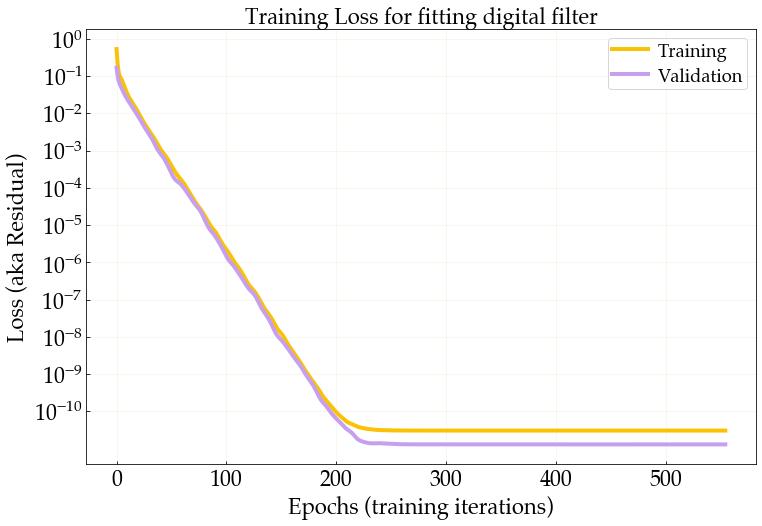

In [ ]:
# plot the "Loss" as a function of training epoch
epoch    = np.arange(0, N_epochs, 1) #(start, stop, step)
loss     = history.history['loss']
val_loss = history.history['val_loss']
print(np.shape(loss))


fig, ax = plt.subplots(1,1)
ax.semilogy(epoch, loss,     c='xkcd:Goldenrod', label='Training', rasterized=True)
ax.semilogy(epoch, val_loss, c='xkcd:Lavender',  label='Validation', rasterized=True)
ax.set_yticks([10**-10,10**-9,10**-8,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2,10**-1,10**0])
ax.set_xlabel('Epochs (training iterations)')
ax.set_ylabel('Loss (aka Residual)')
ax.legend()

ax.set_title('Training Loss for fitting ' + 'digital' + ' filter')
#ax.set_ylim((1e-5, 1))
plt.show()

In [ ]:
# evaluate model
#results = model.evaluate(noisydata_testing, filterdata_testing)

In [ ]:
predictions = model.predict(noisydata_val)
noisydata_training  = noisydata_training.flatten()
noisydata_testing   = noisydata_testing.flatten()
noisydata_val       = noisydata_val.flatten()

filterdata_training = filterdata_training.flatten()
filterdata_testing  = filterdata_testing.flatten()
filterdata_val      = filterdata_val.flatten()
predictions = predictions.flatten()

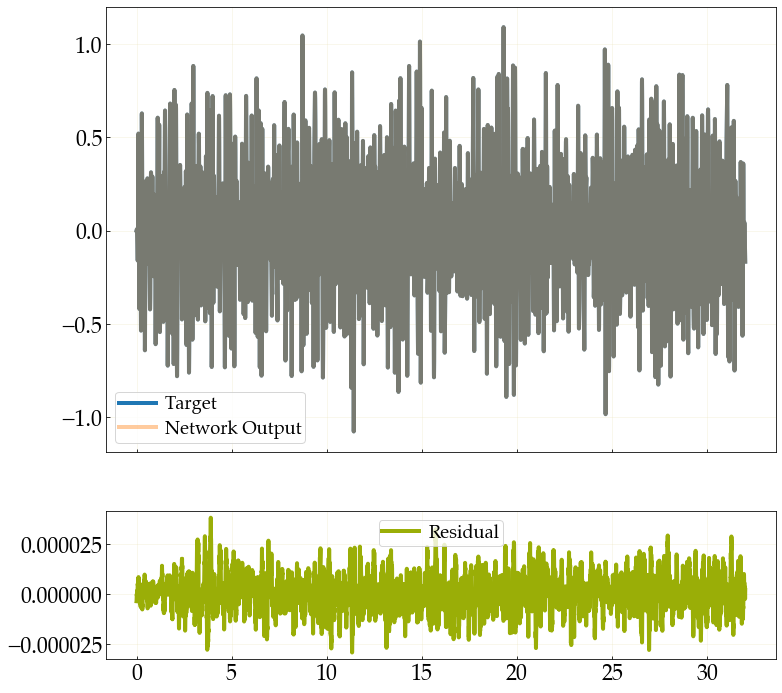

In [ ]:
# Make the plot.

tt = np.arange(len(noisydata_val)) /fs

res = predictions - filterdata_val

# make plots to evaluate success / failure of the regression
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True,
                                       figsize=(12, 12),
                                       gridspec_kw={'height_ratios':[3, 1]})

ax1.plot(tt, filterdata_val, label='Target')
ax1.plot(tt, predictions, alpha=0.4, label='Network Output')

ax2.plot(tt,res, label='Residual',c='xkcd:puke green')

#ax.set_xlabel('time (seconds)')
ax1.legend()
ax2.legend()

#plt.grid(True)
plt.show()

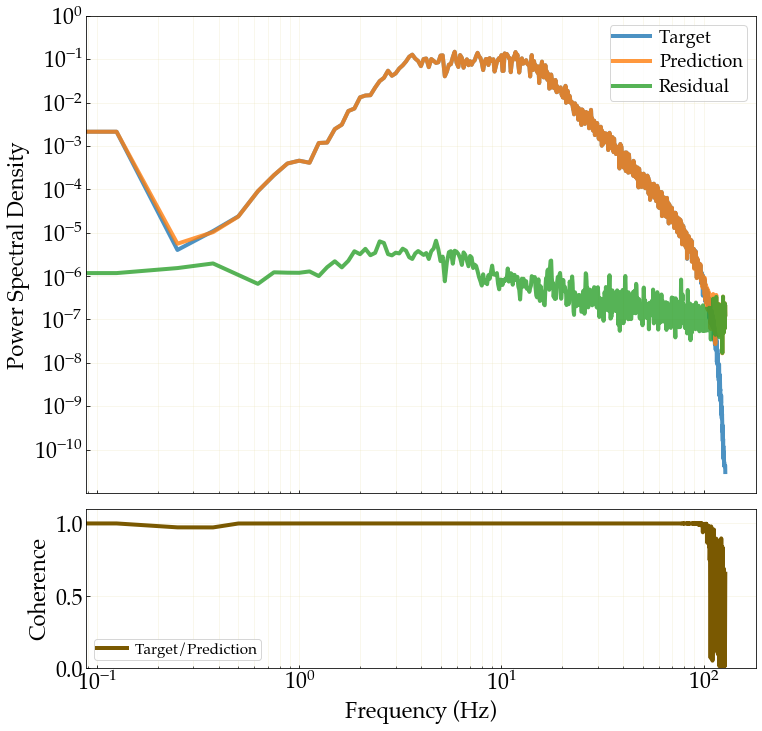

In [ ]:
plot_results(target=filterdata_val, prediction=predictions, fs=fs, nfft=8*fs)

In [ ]:
print(noisydata_training.shape, filterdata_training.shape, noisydata_val.shape, filterdata_val.shape, predictions.shape)

(2048,) (2048,) (8192,) (8192,) (8192,)


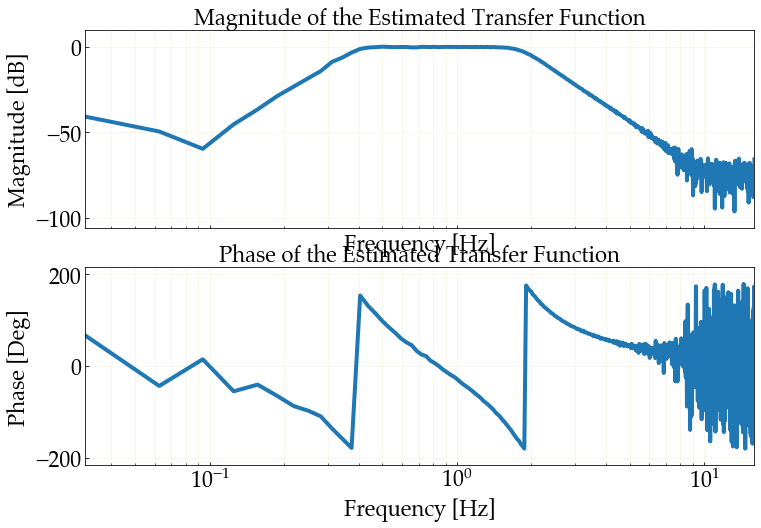

(array([ 4.55175109e-02+0.00000000e+00j,  3.61903874e-03+8.46729666e-03j,
         2.43463845e-03-2.31805869e-03j,  1.01241461e-03+2.61852951e-04j,
         3.10736734e-03-4.46958231e-03j,  1.13091178e-02-9.69853123e-03j,
         1.53449593e-02-3.31215111e-02j,  3.35142547e-03-6.95358828e-02j,
        -1.52259131e-02-1.19822589e-01j, -6.55172584e-02-1.85231316e-01j,
        -2.63782508e-01-2.54179127e-01j, -4.53721367e-01-1.80367644e-01j,
        -6.85065382e-01-2.01888346e-02j, -7.81503609e-01+3.95992665e-01j,
        -6.22578604e-01+7.28711266e-01j, -4.03086383e-01+8.98817942e-01j,
        -1.29106133e-01+1.00861522e+00j,  1.05933672e-01+9.94441766e-01j,
         3.00170446e-01+9.38467597e-01j,  4.99713961e-01+8.63485344e-01j,
         6.22935603e-01+7.80060740e-01j,  6.83695967e-01+6.86892357e-01j,
         8.15926925e-01+5.23329004e-01j,  9.12996549e-01+4.23596593e-01j,
         9.32858861e-01+3.67887678e-01j,  9.69694711e-01+2.01007335e-01j,
         1.00175493e+00+1.08771953e-01

In [ ]:
from tfestimate import tfestimate
tfestimate(noisydata_val,predictions)